

<div style="text-align: right; direction: rtl;">
در این چالش قصد داریم با توجه به تصویری از یک صفحه شطرنج، تشخیص دهیم برنده بازی کیست!

در بازی شطرنج، برنده بازی کسی است که حریف خود را کیش و مات کند. (در مسابقات اگر حریف یک بازیکن باخت خود را قبول کند و یا زمان او به پایان برسد نیز بازنده محسوب می‌شود.)
</div>

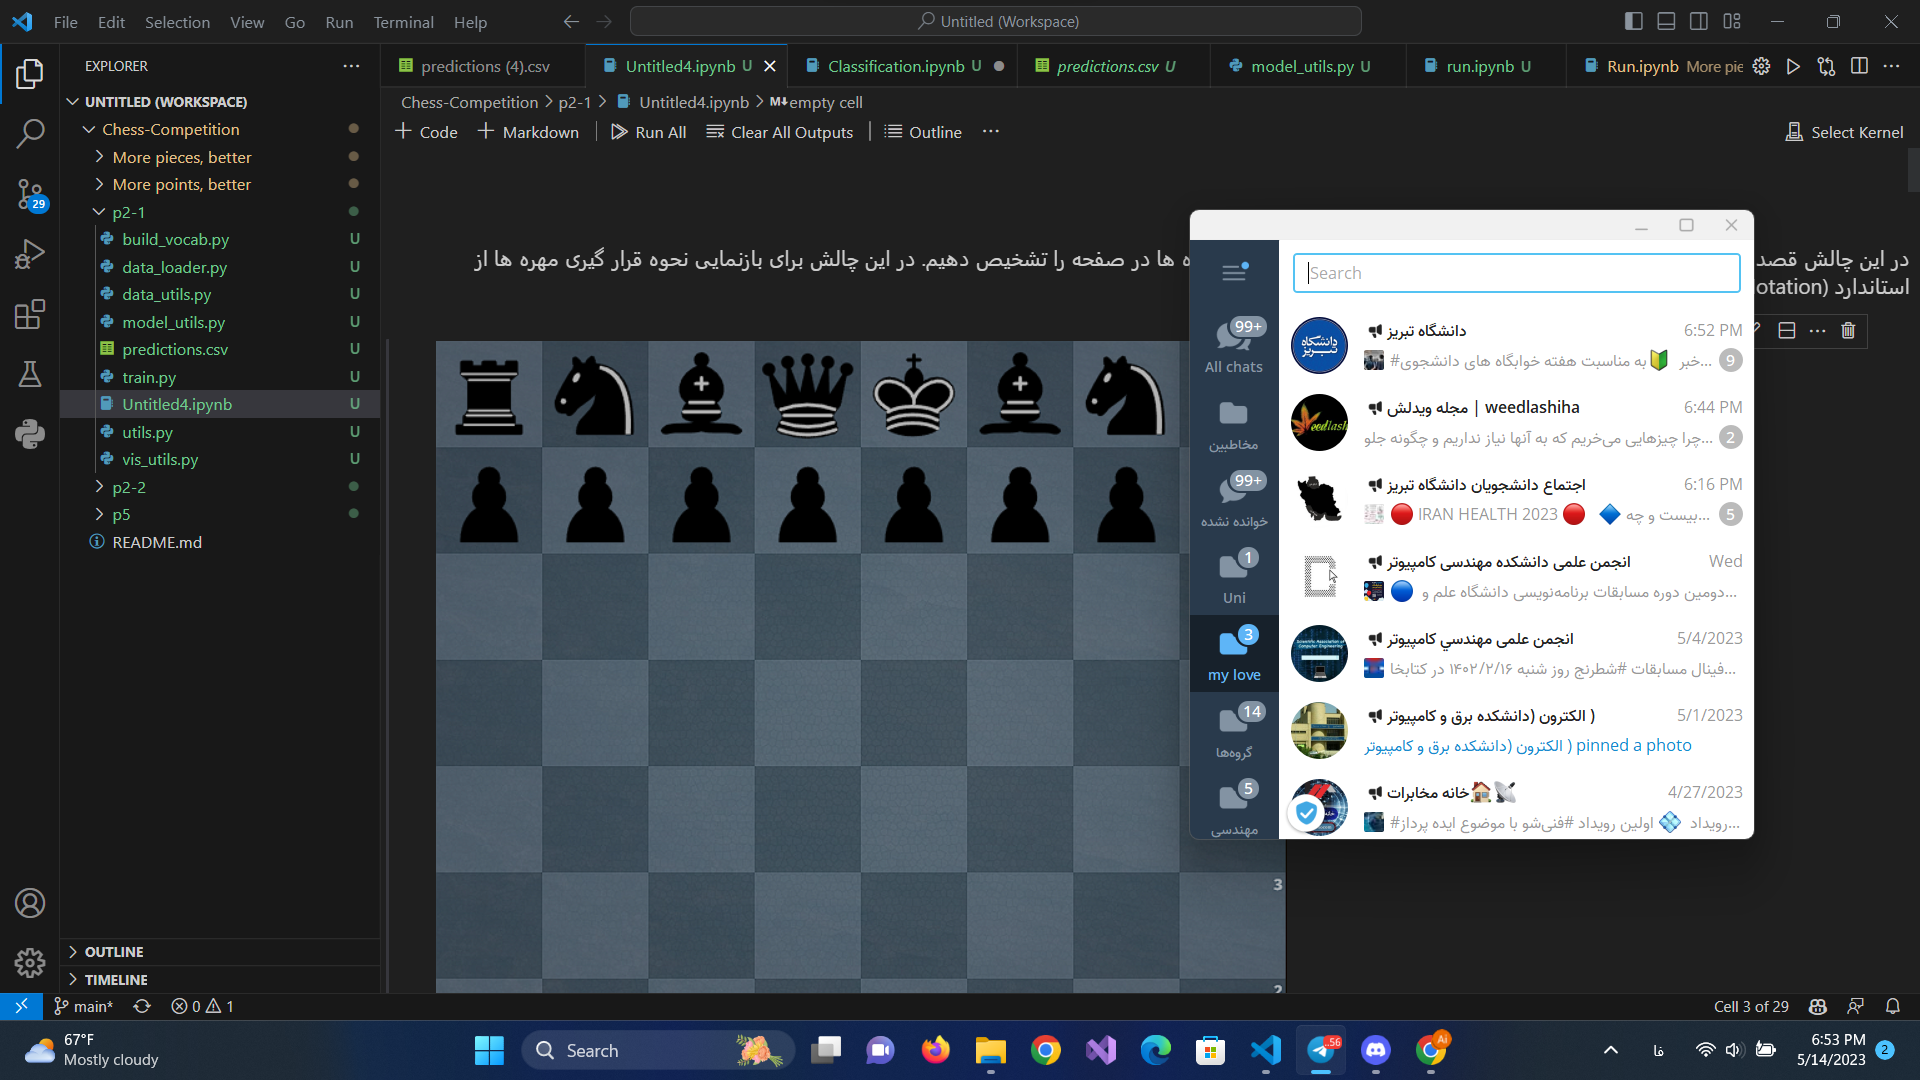

In [56]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Our libraries
from train import train_model
from model_utils import *
# from predict_utils import *
from vis_utils import *

# some initial setup
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)

In [57]:
use_gpu


True

In [58]:
import gc
import torch
torch.cuda.empty_cache()


In [59]:
!nvidia-smi

Sun May 14 18:50:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 522.33       Driver Version: 522.33       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   55C    P8    N/A /  N/A |   1100MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [60]:
DATA_DIR = 'D:/Problem05/'
sz = 224
batch_size = 16

In [61]:
DATA_DIR
os.listdir(DATA_DIR)

['test', 'train', 'valid']

In [62]:
trn_dir = f'{DATA_DIR}train'
val_dir = f'{DATA_DIR}valid'
test_dir=f'{DATA_DIR}test'

In [63]:

os.listdir(trn_dir)

['0', '1']

In [64]:
trn_fnames = glob.glob(f'{trn_dir}/*/*.PNG')
trn_fnames[:5]

['D:/Problem05/train\\0\\img0.png',
 'D:/Problem05/train\\0\\img1.png',
 'D:/Problem05/train\\0\\img10.png',
 'D:/Problem05/train\\0\\img1000.png',
 'D:/Problem05/train\\0\\img10001.png']

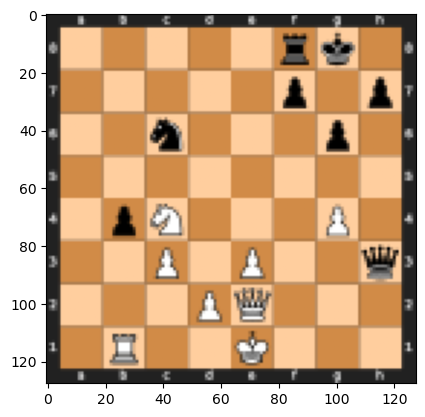

In [65]:
img = plt.imread(trn_fnames[1])
plt.imshow(img);

In [66]:
train_ds = datasets.ImageFolder(trn_dir)

In [67]:
train_ds.classes


['0', '1']

In [68]:
image_size = 150
crop_size  = 128
batch_size = 16



import random
tfms = transforms.Compose([
    
 
    
    transforms.Resize((128, 128)),  # PIL Image
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(2),
    transforms.ColorJitter(.5,.5,.3),
    transforms.ToTensor(),        # Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
   

])

tfmsval = transforms.Compose([
    
    transforms.Resize((128, 128)),  # PIL Image

    transforms.ToTensor(),        # Tensor

    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
   

])


train_ds = datasets.ImageFolder(trn_dir, transform=tfms)
valid_ds = datasets.ImageFolder(val_dir, transform=tfmsval)

In [69]:
# len(train_ds)
len(train_ds)


17703

In [70]:
train_dl = torch.utils.data.DataLoader(train_ds, 
                                       batch_size=batch_size, 
                                       shuffle=True
                                      )

valid_dl = torch.utils.data.DataLoader(valid_ds, 
                                       batch_size=batch_size, 
                                       shuffle=False 
                                       )


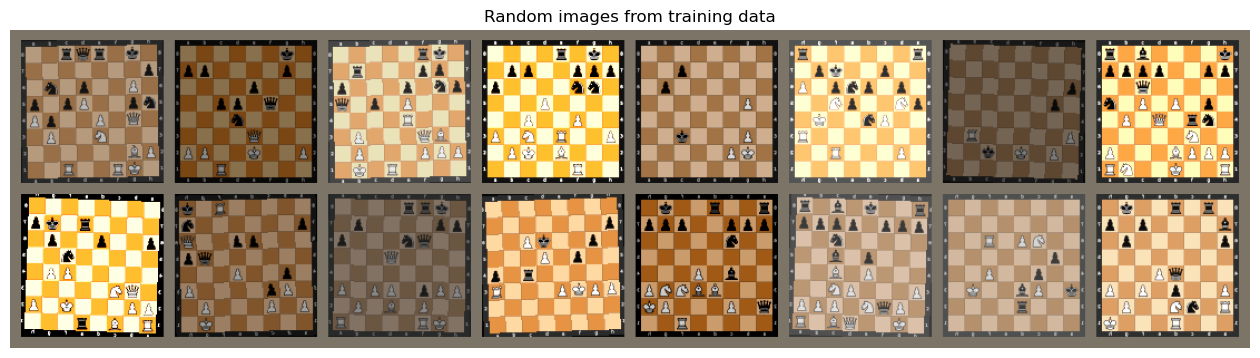

In [71]:

train_ds = datasets.ImageFolder(trn_dir, transform=tfms)


train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)


inputs, targets = next(iter(train_dl))

out = torchvision.utils.make_grid(inputs, padding=10)

plt.figure(figsize=(16, 12))
imshow(out, title='Random images from training data')
plt.show()

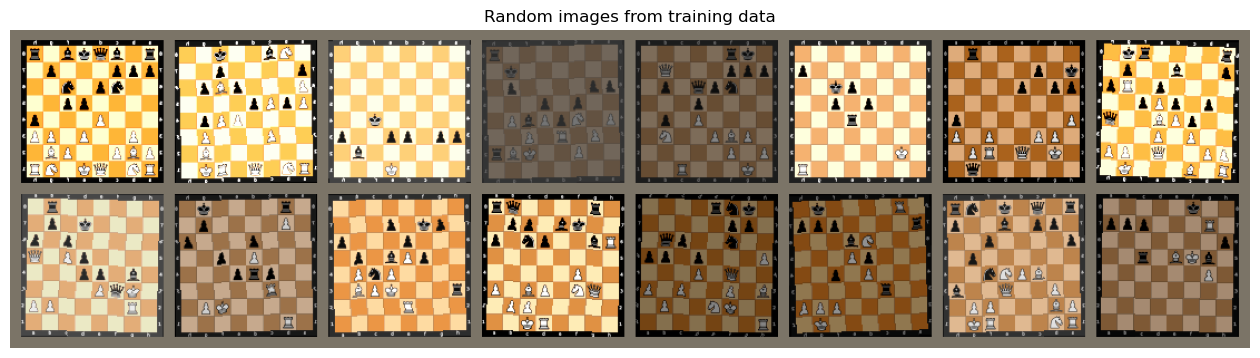

In [72]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=10)
plt.figure(figsize=(16, 12))
imshow(out, title='Random images from training data')


In [73]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2) #64
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2) #32
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
           nn.MaxPool2d(2) #16
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
           nn.MaxPool2d(2) #8
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)  #4
        )
        
        self.fc = nn.Linear(4 * 4* 256, 512)

        self.attention = nn.MultiheadAttention(512, num_heads=8, dropout=0.5)
        self.fc3 = nn.Linear(512, 2)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.view(out.size(0), -1)  # flatten
        out = F.relu(self.fc(out))

        out = out.view(1, -1, 512)
        out, _ = self.attention(out, out, out)
        out = out.view(-1, 512)
        out = self.fc3(out)
        return out



In [74]:
model = CNN()



# transfer model to GPU, if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

In [75]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
#optimizer = optim.SGD(Resnet50.parameters(), lr=0.002, momentum=0.9)

In [76]:
model=train_model(model,train_dl,valid_dl,criterion,optimizer,device,None,10)

Epoch 1/10
----------
  train Loss: 0.69176 Acc: 0.52613
  valid Loss: 0.67813 Acc: 0.59025

Epoch 2/10
----------
  train Loss: 0.67387 Acc: 0.58278
  valid Loss: 0.70087 Acc: 0.57576

Epoch 3/10
----------
  train Loss: 0.65928 Acc: 0.61103
  valid Loss: 0.64250 Acc: 0.63636

Epoch 4/10
----------
  train Loss: 0.64842 Acc: 0.62707
  valid Loss: 0.65025 Acc: 0.61001

Epoch 5/10
----------
  train Loss: 0.63700 Acc: 0.64317
  valid Loss: 0.60969 Acc: 0.67589

Epoch 6/10
----------
  train Loss: 0.62984 Acc: 0.64786
  valid Loss: 0.61519 Acc: 0.64559

Epoch 7/10
----------
  train Loss: 0.61653 Acc: 0.66706
  valid Loss: 0.68181 Acc: 0.60870

Epoch 8/10
----------
  train Loss: 0.61517 Acc: 0.66927
  valid Loss: 0.58362 Acc: 0.68511

Epoch 9/10
----------
  train Loss: 0.60466 Acc: 0.67983
  valid Loss: 0.59097 Acc: 0.68379

Epoch 10/10
----------
  train Loss: 0.59667 Acc: 0.68678
  valid Loss: 0.56347 Acc: 0.69433

Training complete in 10m 16s
Best val Acc: 0.6943


In [77]:
def evaluate_model(model, dataloader, device):
    model.eval()  # for batch normalization layers
    corrects = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))
    

In [78]:

valid_dl = torch.utils.data.DataLoader(valid_ds, 
                                       batch_size=batch_size, 
                                       shuffle=False 
                                       )

  

In [79]:
evaluate_model(model, valid_dl, device)

accuracy: 69.43


In [80]:
def lab(model):
    p=[]
    for i in range(4562):
       
        img_path = f'D:\\Problem05\\test\\img{i}.PNG'
        img = Image.open(img_path)
        img = tfms(img)
        img = img.unsqueeze(0)

        model.eval()  # for batch normalization layers
        with torch.no_grad():
            class_names=['0','1']
            inputs = img.to(device)
            outputs = model(inputs)
            _,preds = torch.max( outputs, 1)
    
            #result=preds[0]['scores'].cpu().numpy()
            result=preds.cpu().numpy()
            pred_class_names = [class_names[i] for i in result]
            p+= pred_class_names
    return p


In [81]:
lab=lab(model)

In [82]:
import csv

with open('predictions.csv', 'w', newline='') as file:
     writer = csv.writer(file)
     for i in range(len(lab)) :
          writer.writerow([f"img{i}", f"{lab[i]}"])
    

In [83]:
evaluate_model(model, train_dl, device)


KeyboardInterrupt: 

In [ ]:
# visualize_model(model, train_dl, device)


In [ ]:
# plot_errors(model, valid_dl, device)


100%|██████████| 109/109 [00:02<00:00, 46.61it/s]


[[0.7  0.3 ]
 [0.28 0.72]]


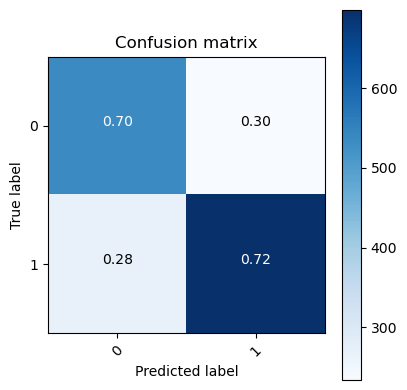

In [ ]:
y_pred, y_true = predict_class(model, valid_dl, device)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(4, 4))